
# Максимально правдоподобная домашка

В этом задании мы с вами отточим метод максимального правдоподобия и выведем лог. регрессию.

In [ ]:
import numpy as np
import pandas as pd

from scipy import stats
from scipy.optimize import minimize

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




$28$ января $1986$ года космический шатл «Челленджер» взорвался при взлёте. Семь астронавтов, находившихся на борту, погибли. В ходе расследования причин катастрофы основной версией была неполадка с резиновыми уплотнительными кольцами в соединении с ракетными ускорителями. Для $23$ предшествовавших катастрофе полётов «Челленджера» известны температура воздуха и появление повреждений хотя бы у одного из уплотнительных колец.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Math & Natural & Finance/Math/Statistics/data/challenger.csv', sep=',')
print(df.shape)
df.head()

(23, 3)


,Date,Temperature,Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
3,01/11/1982,68,0
4,04/04/1983,67,0


## Распределения

Постройте на графиках гистограмму для распределения температуры $(Temperature)$ в ситуациях, когда хотя бы одно кольцо было повреждено $(Incident = 1)$ и в ситуациях, когда ни одного повреждения не было $(Incident = 0)$. 

In [ ]:
df[df['Incident'] == 1]

,Date,Temperature,Incident
1,11/12/1981,70,1
8,02/03/1984,57,1
9,04/06/1984,63,1
10,8/30/84,70,1
13,1/24/85,53,1
20,10/30/85,75,1
22,01/12/1986,58,1


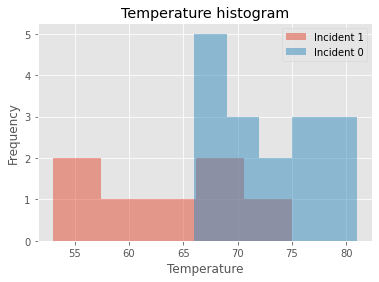

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
i_1 = df[df['Incident'] == 1]['Temperature']
i_0 = df[df['Incident'] == 0]['Temperature']
plt.hist(i_1, bins=5, alpha=0.5, label='Incident 1')
plt.hist(i_0, bins=5, alpha=0.5, label='Incident 0')

# Adding extra features   
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title('Temperature histogram')
plt.legend(loc='upper right')
plt.show()

In [ ]:
df[df['Incident'] == 1].Temperature.mean(), df[df['Incident'] == 0].Temperature.mean()

(63.714285714285715, 72.125)

## LogLoss

Судя по всему, между температурой и вероятностью поломки есть взаимосвязь. Давайте создадим модель для этого...



Пусть вероятность поломки зависит от температуры линейным образом: $z = \beta_0 + \beta_1 \cdot t$ – это будет линейный предиктор. Но для оценки вероятности мы будем использовать функцию "сигмоиду", в которую мы будем передавать наш линейный предиктор $z$:
$$\sigma(z) = \dfrac{1}{1 + e^{-z}}$$

Как вы думаете, почему используется эта функция? Какая у нее область определения и область значений?  
*Область определения $\mathbb{R}$, при этом область значений заключена между $[0, 1]$, что позволяет интерпретировать выходное значение как вероятность.*

Таким образом, мы можем написать, что вероятность поломки может быть описана следующим уравнением
$$
P(Incident = 1) =  \dfrac{1}{1 + e^{-1\cdot(\beta_0 + \beta_1 \cdot t)}} $$

Заметим, что наша целевая переменная бинарная принимает два значения $0$ и $1$, поэтому можем сказать, что каждое наблюдение $y$ из распределения Бернули и даже выписать аналог функции плотности для этого распределения:
$$p(y) = p^{I[y=1]} \cdot (1-p)^{I[y=0]} =  \begin{cases}
   p & \text{если }y=1, \\
   1-p & \text {если } y = 0.
 \end{cases}$$


Но мы рассматриваем не одно наблюдения, а целую выборку, и более того предполагаем, что наша целевая переменная $y_i$ как-то зависит от $x_i$, тогда можем также описать эту взаимосвязь следующим образом:

$$y_i \sim \text{Bernoulli}\left(\dfrac{1}{1 + e^{-1\cdot(\beta_0 + \beta_1 \cdot t)}} \right)$$

Или:

$$p(y_i) = \left( \dfrac{1}{1 + e^{-1\cdot(\beta_0 + \beta_1 \cdot t)}} \right)^{I[y_i=1]} \cdot \left(1- \dfrac{1}{1 + e^{-1\cdot(\beta_0 + \beta_1 \cdot t)}} \right)^{I[y_i=0]}$$

А также выписать правдоподобие для целой выборки:

$$ L =\prod_{i=1}^n p(y_i) = \prod_{i=1}^n \left[ \left( \dfrac{1}{1 + e^{-1\cdot(\beta_0 + \beta_1 \cdot t)}} \right)^{I[y_i=1]} \cdot \left(1- \dfrac{1}{1 + e^{-1\cdot(\beta_0 + \beta_1 \cdot t)}} \right)^{I[y_i=0]} \right]$$
  
А теперь задание!

Выведите функцию логарифма правдоподобия и вбейте ее в python. Мы будем работать с логарифмом правдоподобия с минусом - такая функция называется функцей потерь `logloss`


$logL = \sum_{i=1}^{n}\left[ I[y_i=1] \cdot \left( \dfrac{1}{1 + e^{-1\cdot(\beta_0 + \beta_1 \cdot t)}} \right) + I[y_i=0] \cdot \left(1- \dfrac{1}{1 + e^{-1\cdot(\beta_0 + \beta_1 \cdot t)}} \right) \right]$

In [ ]:
df[['Temperature', 'Incident']]

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
import math

def lnL(theta, data):
    a, b = theta
    
    # your code here
    logloss = 0
    for ind in df.index:
      p = 1/(1+math.exp(-a-b*df['Temperature'][ind]))
      if df['Incident'][ind] == 1:
        logloss += math.log(p)
      elif df['Incident'][ind] == 0:
        logloss += math.log(1-p)
    return -logloss

In [ ]:
assert np.abs(lnL([4, 0.2], df) - 294.8) < 1e-4

In [ ]:
lnL([4, 0.2], df)

294.80000110259067

## Оценка параметров

Оцените параметры $\beta_0$ и $\beta_1$ с помощью метода максимального правдоподобия. 

Для этого решите задачу оптимизации поиска коэффициентов $\beta_0$ и  $\beta_1$, используя функцию `minimize` из `scipy.optimize` (под капотом реализован градиентный спуск). 

В эту функцию нужно передать 
- `fun` - минимизируемую функцию потерь
- `x0` -  стартовые точки 
- `args=()` - сюда можно передать датафрейм, по которому будет считаться функция потерь и к которому вы будете обращаться внутри функции потерь




In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
import scipy
from scipy.optimize import minimize

theta_init = [1, 0.1]
res = minimize(fun=lnL, x0=theta_init, args=df)

In [ ]:
assert np.abs(res.fun - 10.1576) < 1e-4

In [ ]:
res.x

array([15.04297474, -0.23216381])

## Тест отношения правдоподобия



Пусть имеется некоторая линейная модель с вектором параметров $\beta$. Необходимо проверить гипотезу $H_0$ о том, что некоторые компоненты вектора $\beta$ равны нулю. 

Если часть из них равна нулю, то мы получим некоторую модель с ограничениями (R, restricted). Если же эти параметры не равны 0, то мы имеем модель без ограничений (UR, unrestricted). 

Оказывается, что отношение правдоподобия двух таких моделей имеет $\chi^2(q)$ распределение с $q$ степенями свободы, где $q$ — это количество ограничений.

$$LR=2(l_{UR}-l_R)=2\ln \frac {L_R}{L_{UR}} \sim \chi^2(q)$$

где $l_{UR}, ~l_R$ — значения логарифмической функции правдоподобия модели без ограничений и с ограничениями соответственно. 

Поэтому, если значение статистики $LR$ больше критического значения распределения $\chi^2(q)$ при заданном уровне значимости, то ограничения отвергаются, и предпочтение отдаётся модели без ограничений. В противном случае предпочтение отдаётся модели с ограничениями.


Задание!

С помощью теста отношения правдоподобий на уровне значимости $5\%$ проверьте гипотезу о том, что модель не значима, то есть $\beta_0 = \beta_1 = 0$.

**Вопросик.замечание (мб не оправданное):** я тут почитал интернеты [[1](https://en.wikipedia.org/wiki/Likelihood-ratio_test), [2](https://www.statology.org/likelihood-ratio-test-in-python/)], и там значение $LR$ расчитывается как $-2 \cdot (l_{UR} - l_{R})$

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
lnL_un = lnL(res.x, df)
lnL_r = lnL([0, 0], df)

LR_obs = -2*(lnL_un-lnL_r) #minus sign bofore the expression
LR_crit = scipy.stats.chi2.ppf(1-0.05, df=2)


In [ ]:
assert np.abs(lnL_un - 10.1576) < 1e-4

In [ ]:
if LR_obs > LR_crit:
  print('Reject the H_0: b0 = b1 = 0')
else:
  print('Do not reject the H_0: b0 = b1 = 0')

Reject the H_0: b0 = b1 = 0


На уровне значимости $5 \%$ гипотеза о незначимости коэффициентов **отвергается**.

## Предсказание

В день катастрофы температура уплотнителя была $31$ градус по Фарингейту. Предскажите с помощью построенной модели вероятность катастрофы (для этого подставьте в формулу поиска вероятности получившиеся оценки и температуру).

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz

xnew = 31
beta0, beta1 = res.x

p_hat = 1/(1+math.exp(-beta0-beta1 * xnew))


In [ ]:
assert np.abs(p_hat - 0.9996) < 1e-4

## statsmodels



А сейчас, давайте сделаем финальный штрих и оценим ту же самую моделю с помощью пакета `statsmodels`.

In [ ]:
import statsmodels.formula.api as smf

model = smf.logit(data=df, formula='Incident ~ 1 + Temperature').fit()
model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.441635
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Incident   No. Observations:                   23
Model:                          Logit   Df Residuals:                       21
Method:                           MLE   Df Model:                            1
Date:                Wed, 27 Jul 2022   Pseudo R-squ.:                  0.2813
Time:                        10:40:41   Log-Likelihood:                -10.158
converged:                       True   LL-Null:                       -14.134
Covariance Type:            nonrobust   LLR p-value:                  0.004804
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      15.0429      7.379      2.039      0.041       0.581      29.505
Temperature    -0.2322      0.108     -2.145      0.032      -0.444      -0.020
===============================================================================
"""

Посмотрев на протокол, получившийся в результате оценивания модели ответьте на вопросы: 

- Чему равно значение логарифма правдоподобия? Запишите это значение в `logLik`
- Чему равна оценка константы $\beta_0$? Запишите это значение в `beta0`
- По свойствам метода максимального правдоподобия $\hat{\beta} \sim N(\beta, \hat{\sigma}^2_{\beta})$, чему равно значение $\hat{\sigma}_{\beta}$? Запишите это значение в `std_beta`
- Чему равно p-значение для гипотезы $H_0: \beta_1 = 0$? Запишите это значение в `pval_beta`
- Отвергается ли гипотеза $H_0: \beta = 0$ на $5\%$ уровне значимости? Если да, запишите в `is_h` значение `False`

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz

logLik = -10.158
beta0 = 15.0429
std_beta = 0.108
pval_beta = 0.032
is_h = False #reject the null: llr p-value << 0.05


In [ ]:
assert np.abs(logLik + 10.158) < 1e-4

Если вы решили эту ДЗ, то вы – герой! Поздравляю!